# **Importing library&function**






In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [4]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.70,0.15,0.15))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [01:20, 52.47 files/s] 

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 162 images in './outputgrayscale/test/gray_normal'.
There are 0 directories and 166 images in './outputgrayscale/test/gray_diabetic_retinopathy'.
There are 0 directories and 154 images in './outputgrayscale/test/gray_glaucoma'.
There are 0 directories and 158 images in './outputgrayscale/test/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 751 images in './outputgrayscale/train/gray_normal'.
There are 0 directories and 769 images in './outputgrayscale/train/gray_diabetic_retinopathy'.
There are 0 directories and 711 images in './outputgrayscale/train/gray_glaucoma'.
There are 0 directories and 733 images in './outputgrayscale/train/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 161 images in './outputgrayscale/

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [6]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

# **Batch size: 16**

In [7]:
epoch = 20
batchsize = 16

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 2964 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 634 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [9]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 3s 0us/step


In [10]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
 activation (Activation)     (None, 4)                 0     

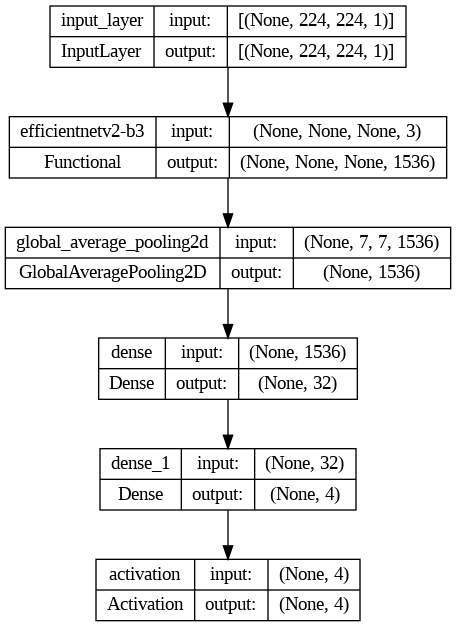

In [11]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [12]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [13]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
186/186 [==============================] - 32s 73ms/step - loss: 0.6498 - accuracy: 0.7260 - val_loss: 0.4619 - val_accuracy: 0.8123 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 10s 55ms/step - loss: 0.4640 - accuracy: 0.8192 - val_loss: 0.4469 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 10s 55ms/step - loss: 0.4145 - accuracy: 0.8340 - val_loss: 0.4069 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 11s 57ms/step - loss: 0.3860 - accuracy: 0.8536 - val_loss: 0.3338 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 11s 56ms/step - loss: 0.3764 - accuracy: 0.8499 - val_loss: 0.3401 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 11s 57ms/step - loss: 0.3404 - accuracy: 0.8671 - val_loss: 0.3246 - val_accuracy: 0.8849 - lr: 0.0010
Epoch 7/20
186/186 [==============================] - 11s 

EfficientNetV2B3 Evaluation

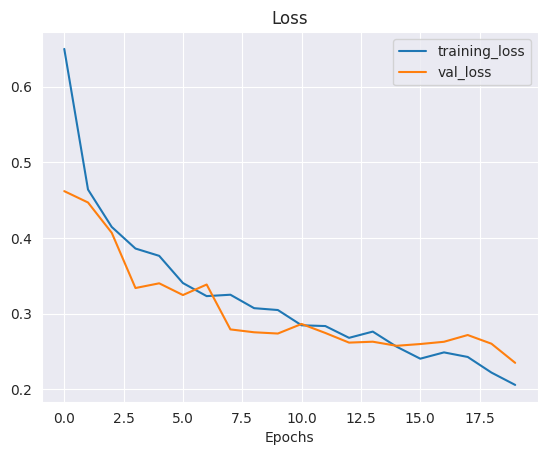

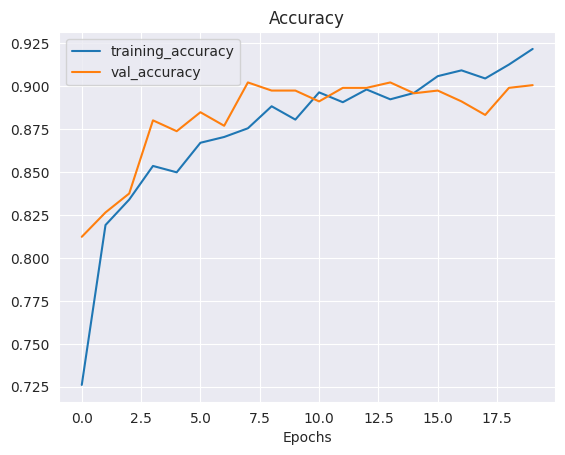

In [14]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 2s 42ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       158
           1       0.96      0.96      0.96       166
           2       0.85      0.83      0.84       154
           3       0.87      0.86      0.86       162

    accuracy                           0.90       640
   macro avg       0.89      0.89      0.89       640
weighted avg       0.90      0.90      0.90       640

Specificity: [0.29554655870445345, 0.3333333333333333, 0.25, 0.2774451097804391]
Mean Squared Error: : 0.11137384176254272
The average AUC-ROC is 0.982703323740667


[0.9748427672955975,
 0.6666666666666666,
 0.6912065439672802,
 0.68125,
 0.6540880503144654,
 0.9873417721518988,
 0.6625766871165644,
 0.6625,
 0.7023060796645703,
 0.679324894514768,
 0.9468302658486708,
 0.7041666666666667,
 0.6687631027253669,
 0.6666666666666666,
 0.6993865030674846,
 0.9520833333333333]

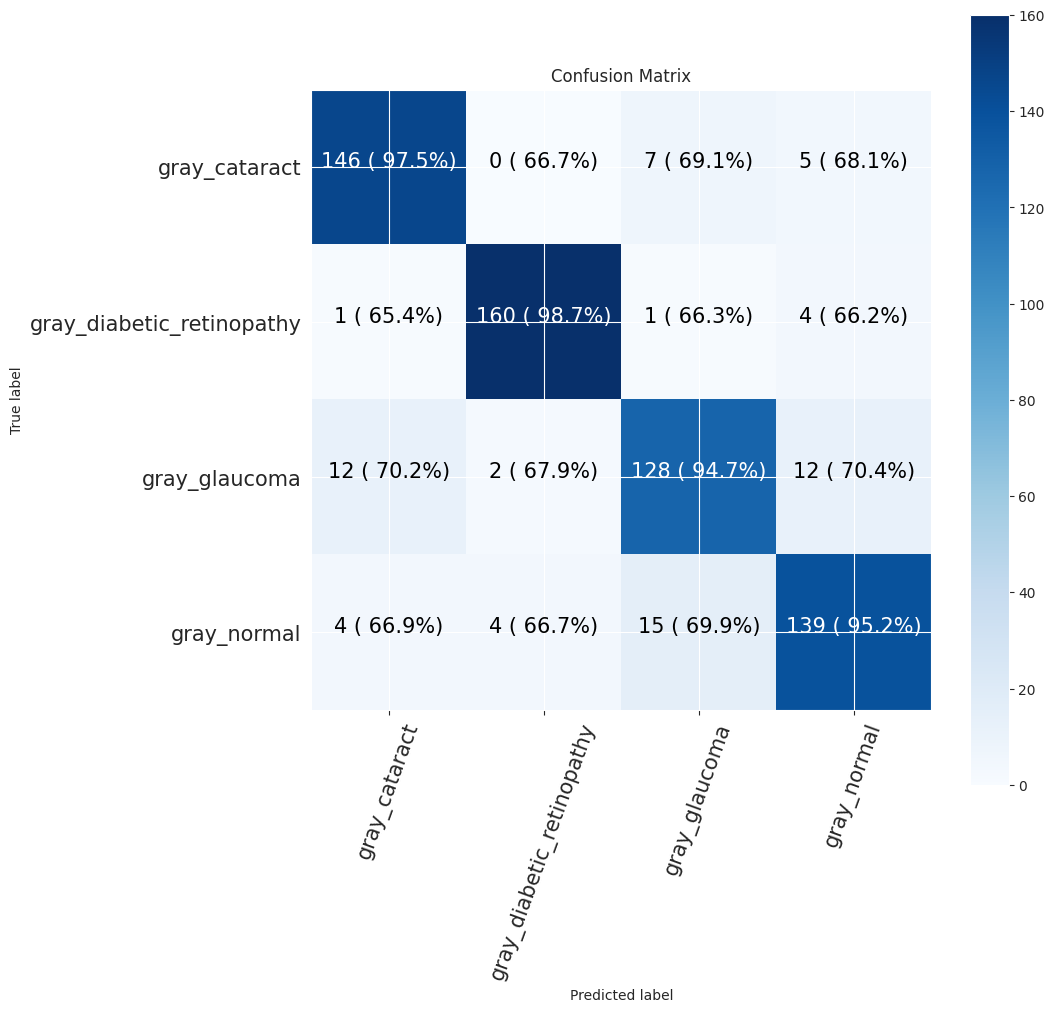

In [15]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


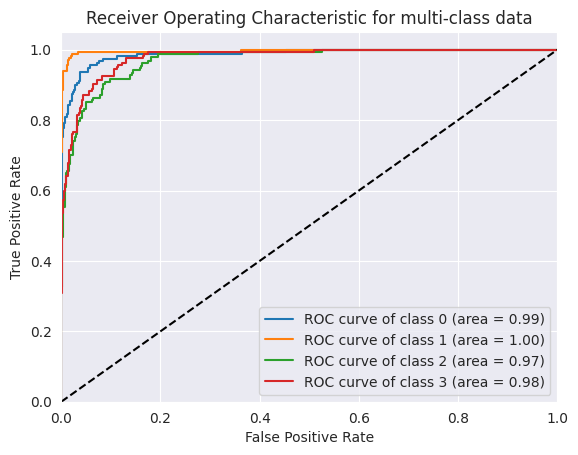

In [16]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [17]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

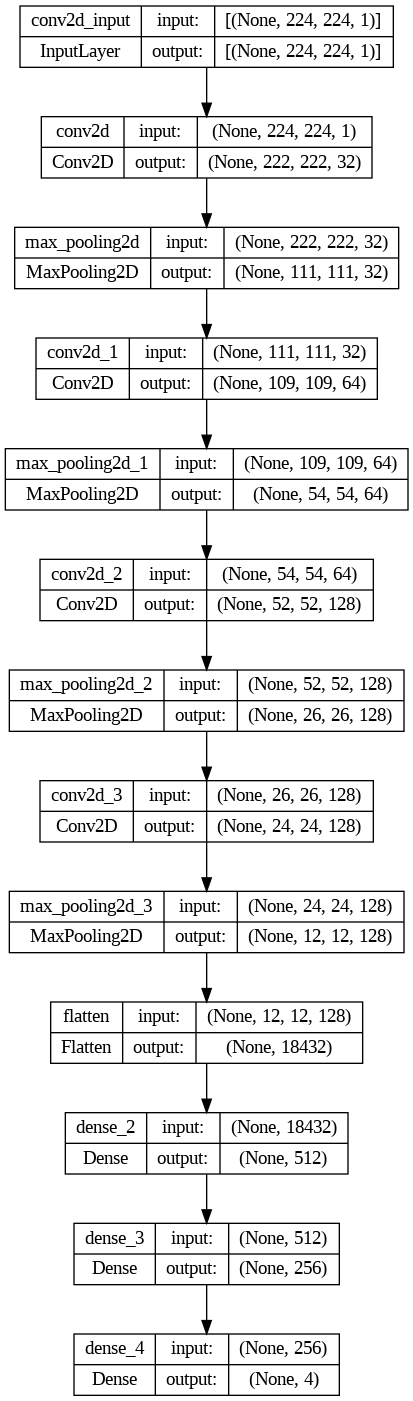

In [18]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [19]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [20]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
186/186 [==============================] - 9s 24ms/step - loss: 2.1202 - accuracy: 0.5945 - val_loss: 0.7836 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 4s 22ms/step - loss: 0.6309 - accuracy: 0.7169 - val_loss: 0.6482 - val_accuracy: 0.7192 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 4s 22ms/step - loss: 0.5934 - accuracy: 0.7287 - val_loss: 0.6150 - val_accuracy: 0.7303 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 4s 22ms/step - loss: 0.6120 - accuracy: 0.7190 - val_loss: 0.6054 - val_accuracy: 0.7429 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 4s 22ms/step - loss: 0.5690 - accuracy: 0.7345 - val_loss: 0.6694 - val_accuracy: 0.7287 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 4s 22ms/step - loss: 0.5584 - accuracy: 0.7446 - val_loss: 0.5731 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 7/20
186/186 [==============================] - 4s 22ms/st

CNN Evaluation

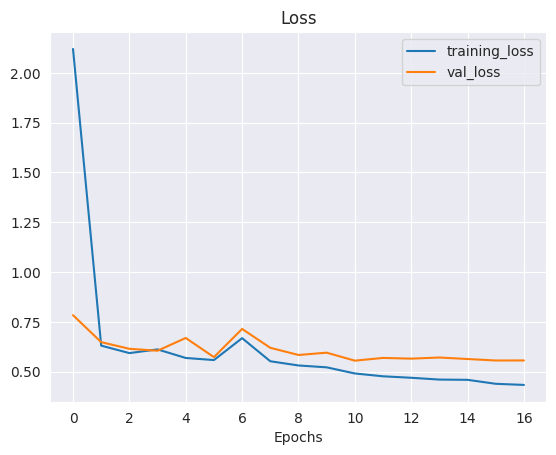

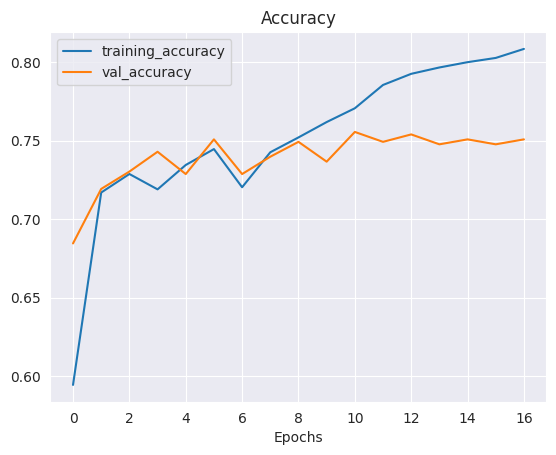

In [21]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.47      0.54       158
           1       0.99      1.00      1.00       166
           2       0.61      0.56      0.59       154
           3       0.70      0.91      0.79       162

    accuracy                           0.74       640
   macro avg       0.73      0.74      0.73       640
weighted avg       0.74      0.74      0.73       640

Specificity: [0.13274336283185842, 0.350210970464135, 0.15732368896925858, 0.29817444219066935]
Mean Squared Error: : 0.13523860275745392
The average AUC-ROC is 0.9057184719047796


[0.8397683397683398,
 0.6659619450317125,
 0.7811244979919679,
 0.7122969837587007,
 0.6795366795366795,
 1.0,
 0.6666666666666666,
 0.6148491879350348,
 0.777992277992278,
 0.6744186046511628,
 0.8654618473895582,
 0.7076566125290024,
 0.7027027027027027,
 0.6596194503171248,
 0.6867469879518072,
 0.9651972157772621]

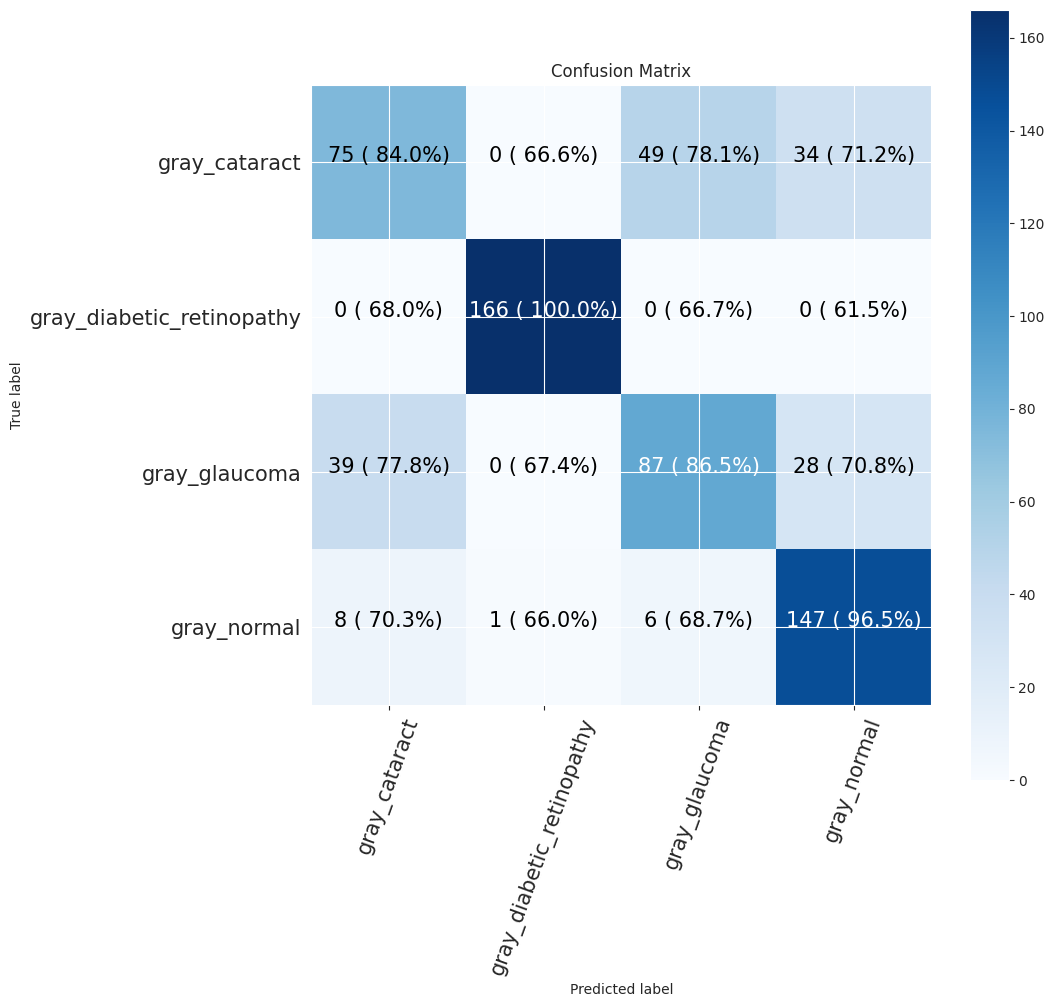

In [22]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


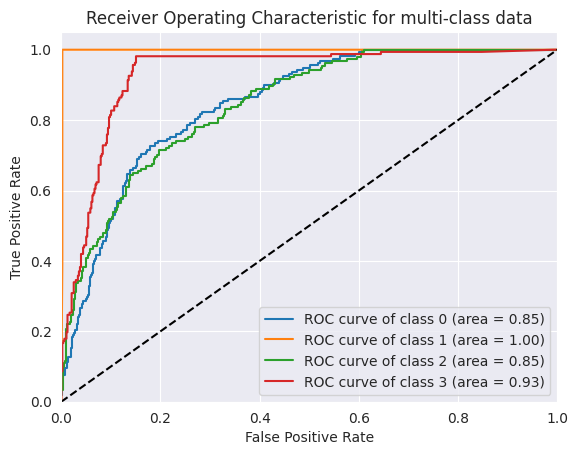

In [23]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [24]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


94765736/94765736 [==============================] - 4s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 4)                 4100 

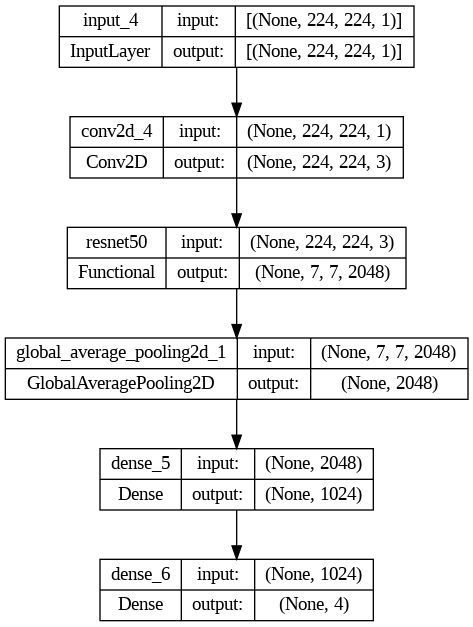

In [25]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [26]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [27]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
186/186 [==============================] - 34s 152ms/step - loss: 0.6160 - accuracy: 0.7794 - val_loss: 0.3705 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 26s 141ms/step - loss: 0.3790 - accuracy: 0.8489 - val_loss: 0.4142 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 26s 139ms/step - loss: 0.3209 - accuracy: 0.8725 - val_loss: 0.3237 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 26s 140ms/step - loss: 0.2904 - accuracy: 0.8836 - val_loss: 0.3113 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 26s 140ms/step - loss: 0.2681 - accuracy: 0.8927 - val_loss: 0.4327 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 26s 140ms/step - loss: 0.2572 - accuracy: 0.8930 - val_loss: 0.3010 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 7/20
186/186 [==============================] 

ResNet50 Evaluation

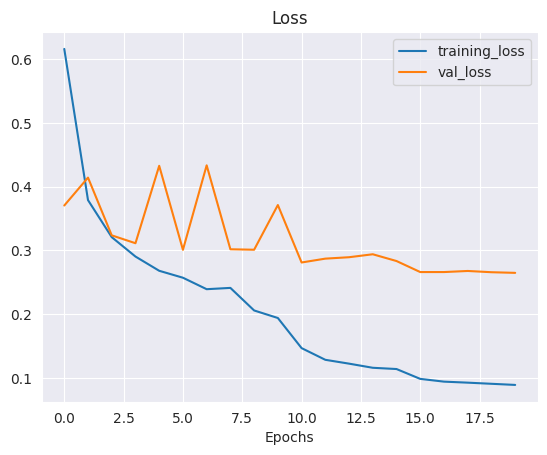

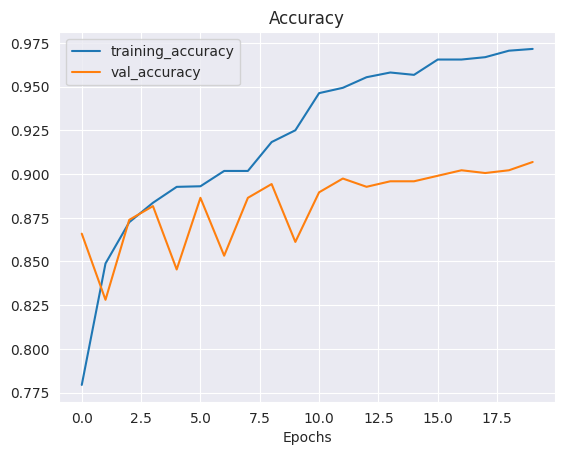

In [28]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 2s 48ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       158
           1       0.98      0.99      0.98       166
           2       0.81      0.84      0.82       154
           3       0.86      0.86      0.86       162

    accuracy                           0.89       640
   macro avg       0.89      0.89      0.89       640
weighted avg       0.89      0.89      0.89       640

Specificity: [0.2698412698412698, 0.3445378151260504, 0.25244618395303325, 0.2774451097804391]
Mean Squared Error: : 0.10978752374649048
The average AUC-ROC is 0.98066172615658


[0.9550102249488752,
 0.6659619450317125,
 0.7,
 0.6861924686192469,
 0.6605316973415133,
 0.9957716701902748,
 0.65625,
 0.6548117154811716,
 0.7055214723926381,
 0.6765327695560254,
 0.9479166666666666,
 0.7071129707112971,
 0.6789366053169734,
 0.6617336152219874,
 0.6958333333333333,
 0.9518828451882845]

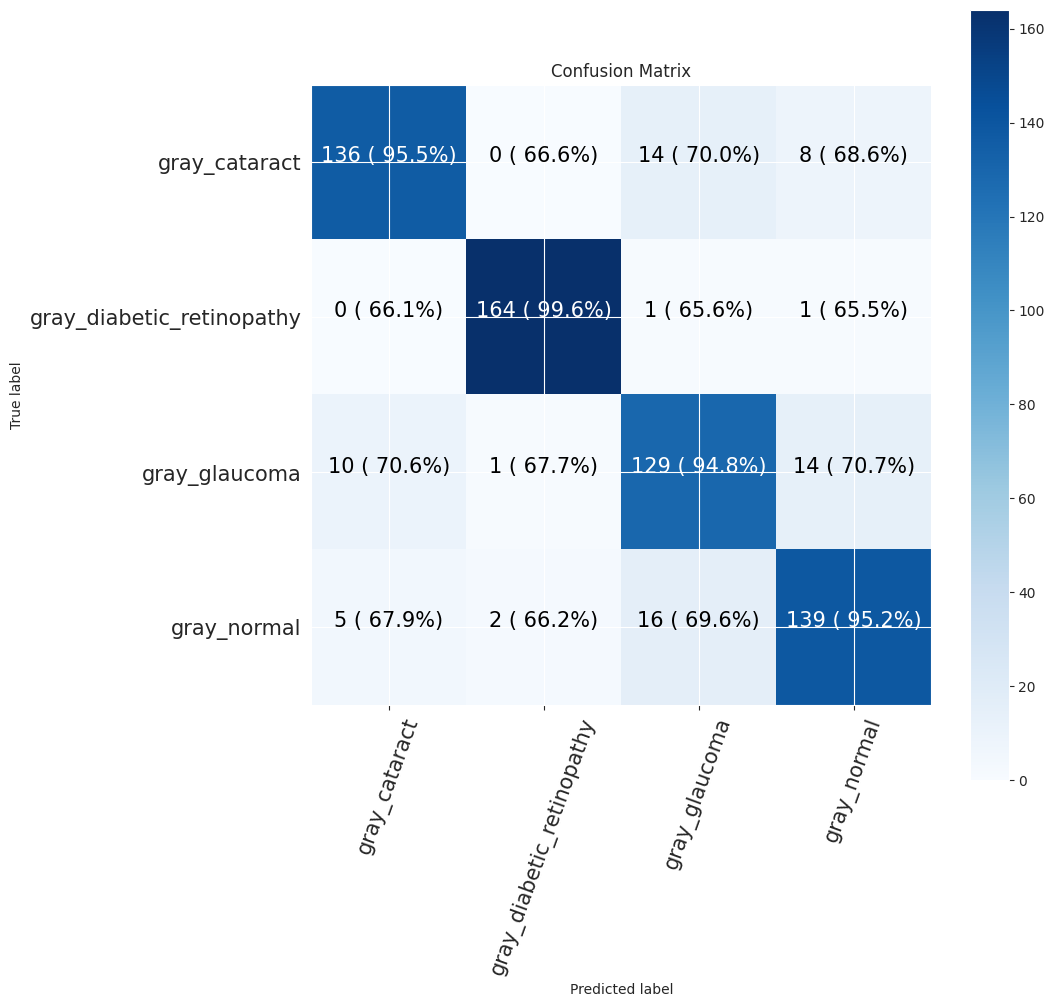

In [29]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


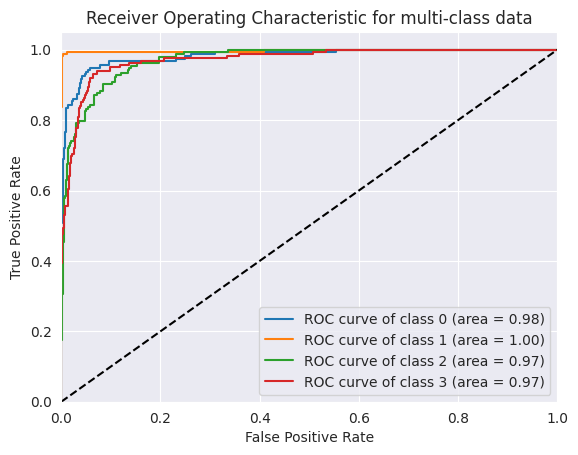

In [30]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [31]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


171446536/171446536 [==============================] - 8s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 4)                 410

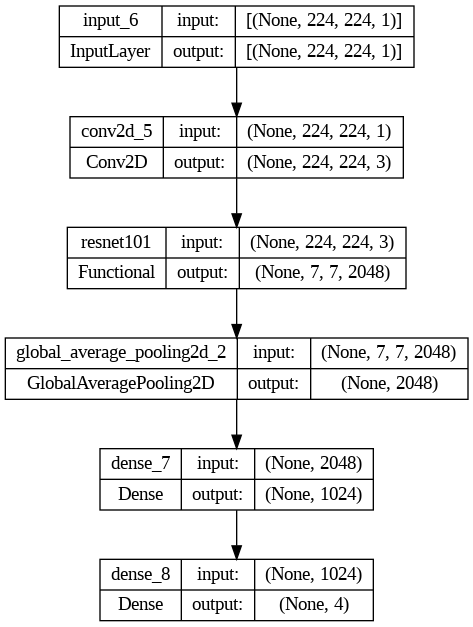

In [32]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [33]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [34]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
186/186 [==============================] - 52s 241ms/step - loss: 0.6180 - accuracy: 0.7790 - val_loss: 0.4722 - val_accuracy: 0.8297 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 43s 229ms/step - loss: 0.3668 - accuracy: 0.8596 - val_loss: 0.5009 - val_accuracy: 0.8044 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 43s 230ms/step - loss: 0.3305 - accuracy: 0.8755 - val_loss: 0.3391 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 43s 230ms/step - loss: 0.2867 - accuracy: 0.8836 - val_loss: 0.2983 - val_accuracy: 0.8849 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 43s 230ms/step - loss: 0.2829 - accuracy: 0.8910 - val_loss: 0.7956 - val_accuracy: 0.7445 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 43s 230ms/step - loss: 0.2708 - accuracy: 0.8961 - val_loss: 0.3347 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 7/20
186/186 [==============================] 

ResNet101 Evaluation

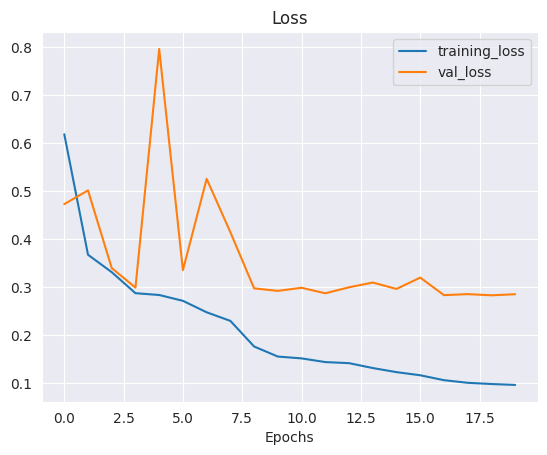

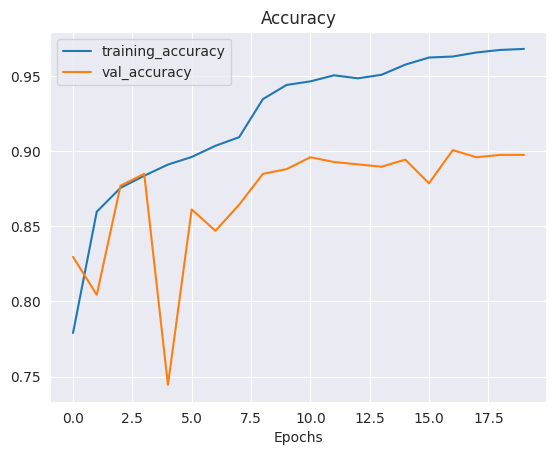

In [35]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 3s 82ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       158
           1       0.98      0.98      0.98       166
           2       0.77      0.81      0.79       154
           3       0.84      0.78      0.81       162

    accuracy                           0.87       640
   macro avg       0.86      0.86      0.86       640
weighted avg       0.87      0.87      0.87       640

Specificity: [0.28, 0.3417190775681342, 0.24271844660194175, 0.245136186770428]
Mean Squared Error: : 0.113008052110672
The average AUC-ROC is 0.9750134344529637


[0.9623430962343096,
 0.6666666666666666,
 0.694560669456067,
 0.689795918367347,
 0.6548117154811716,
 0.9936708860759493,
 0.6548117154811716,
 0.6632653061224489,
 0.702928870292887,
 0.6751054852320675,
 0.9393305439330544,
 0.7204081632653061,
 0.6799163179916318,
 0.6645569620253164,
 0.7112970711297071,
 0.926530612244898]

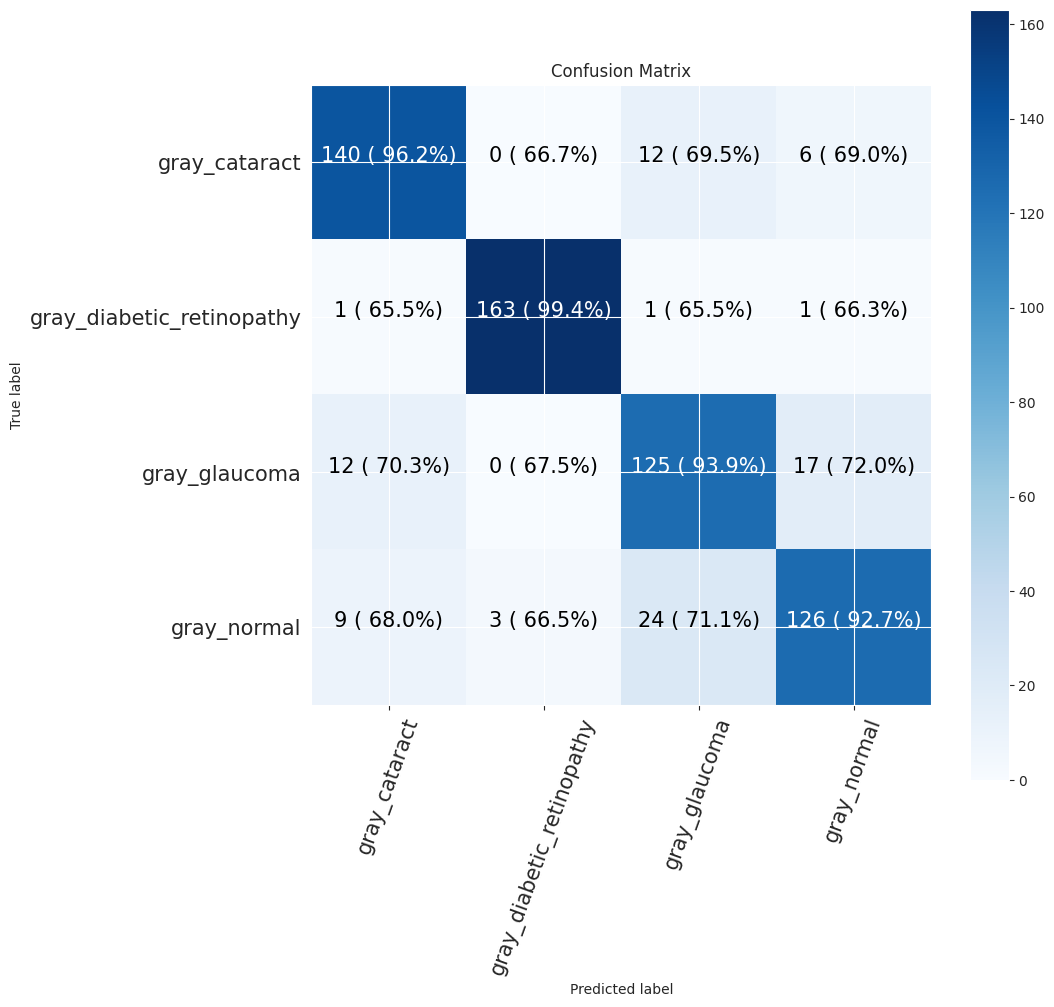

In [36]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


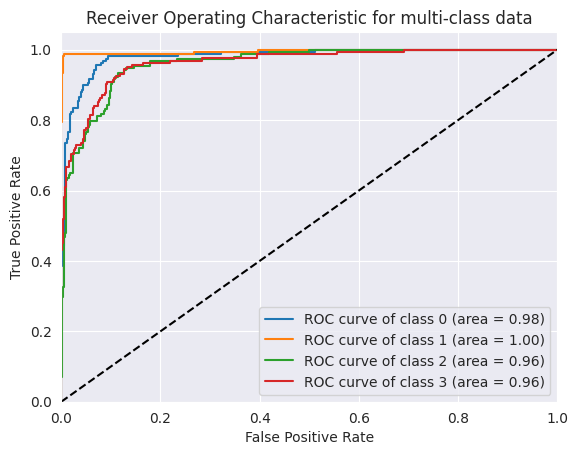

In [37]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [38]:
epoch = 20
batchsize = 32

In [39]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 2964 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 634 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [40]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [41]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 32)                49184     
                                                                 
 dense_10 (Dense)            (None, 4)                 132       
                                                                 
 activation_1 (Activation)   (None, 4)                 0   

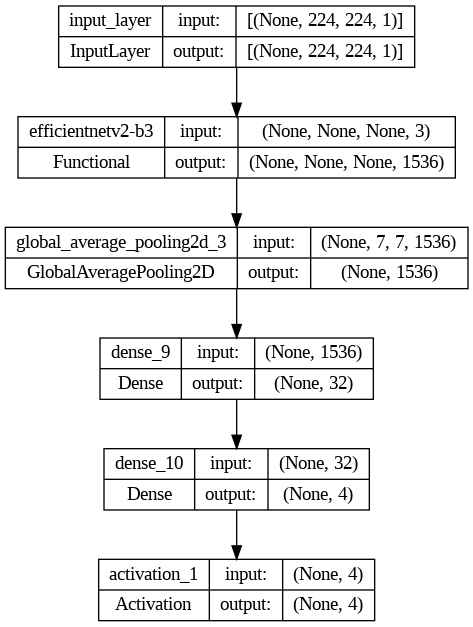

In [42]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [43]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [44]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
93/93 [==============================] - 24s 145ms/step - loss: 0.7129 - accuracy: 0.7179 - val_loss: 0.4996 - val_accuracy: 0.8202 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 10s 104ms/step - loss: 0.4840 - accuracy: 0.8107 - val_loss: 0.4152 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 10s 105ms/step - loss: 0.4478 - accuracy: 0.8279 - val_loss: 0.3901 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 10s 105ms/step - loss: 0.4008 - accuracy: 0.8492 - val_loss: 0.3429 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 10s 104ms/step - loss: 0.3849 - accuracy: 0.8573 - val_loss: 0.3614 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 10s 103ms/step - loss: 0.3593 - accuracy: 0.8674 - val_loss: 0.3135 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 10s 103ms/st

EfficientNetV2B3 Evaluation

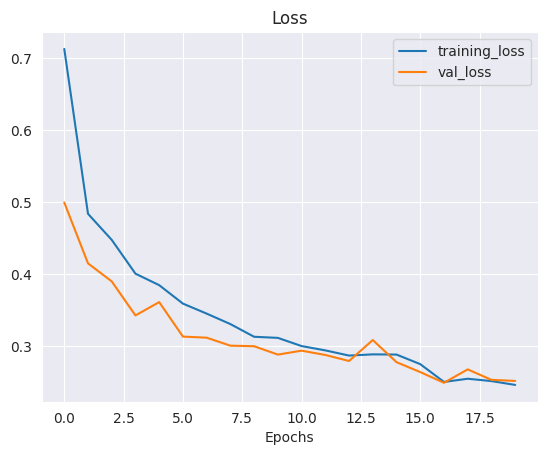

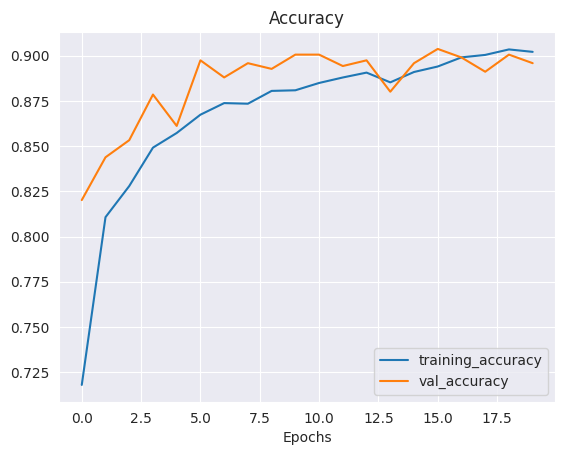

In [45]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2s 78ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       158
           1       0.98      0.95      0.96       166
           2       0.84      0.81      0.83       154
           3       0.83      0.91      0.87       162

    accuracy                           0.89       640
   macro avg       0.89      0.89      0.89       640
weighted avg       0.89      0.89      0.89       640

Specificity: [0.28256513026052105, 0.3250517598343685, 0.24271844660194175, 0.3008130081300813]
Mean Squared Error: : 0.11203883588314056
The average AUC-ROC is 0.9819555854454376


[0.9650924024640657,
 0.6708333333333333,
 0.7012195121951219,
 0.6702819956616052,
 0.6611909650924025,
 0.98125,
 0.6686991869918699,
 0.6507592190889371,
 0.702258726899384,
 0.6791666666666667,
 0.9410569105691057,
 0.7093275488069414,
 0.6714579055441479,
 0.66875,
 0.6890243902439024,
 0.9696312364425163]

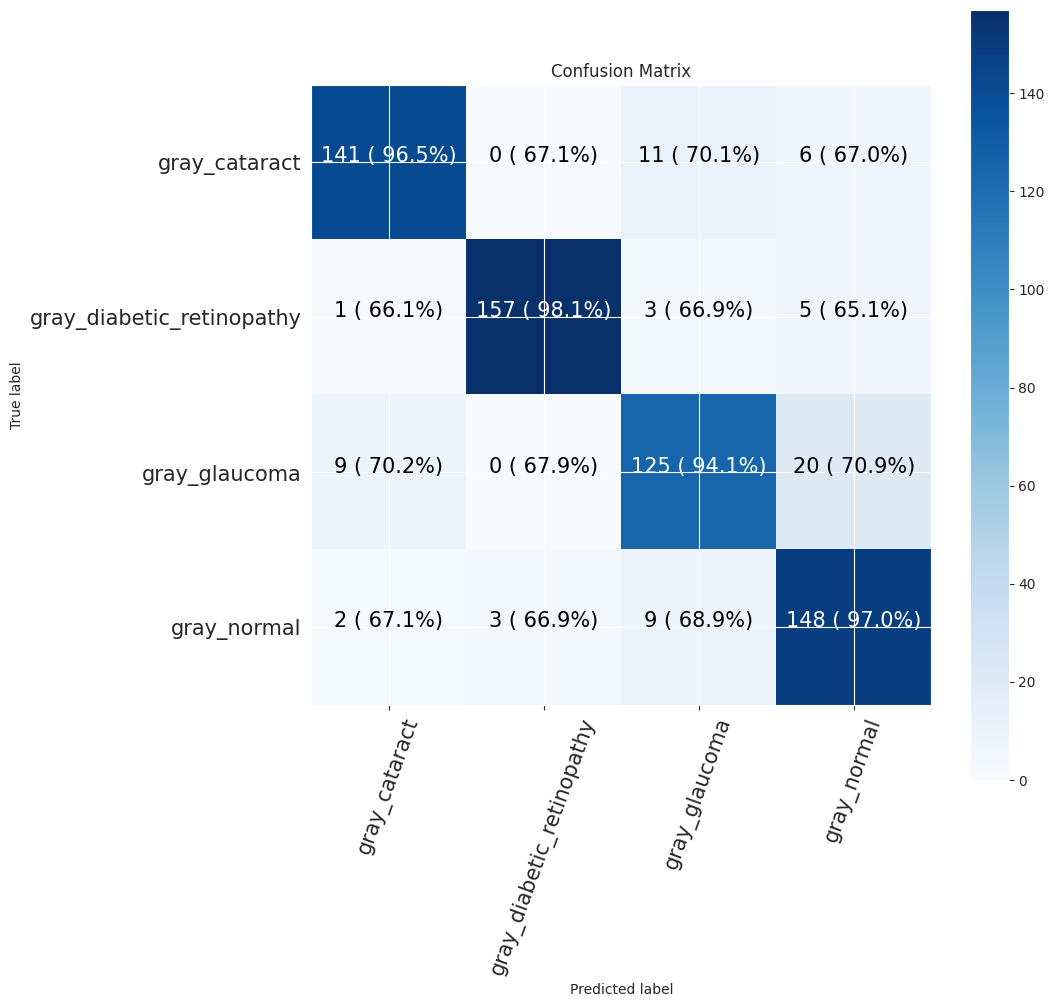

In [46]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


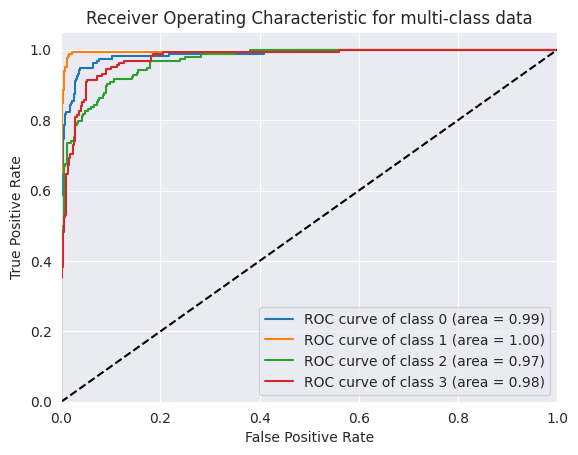

In [47]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [48]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

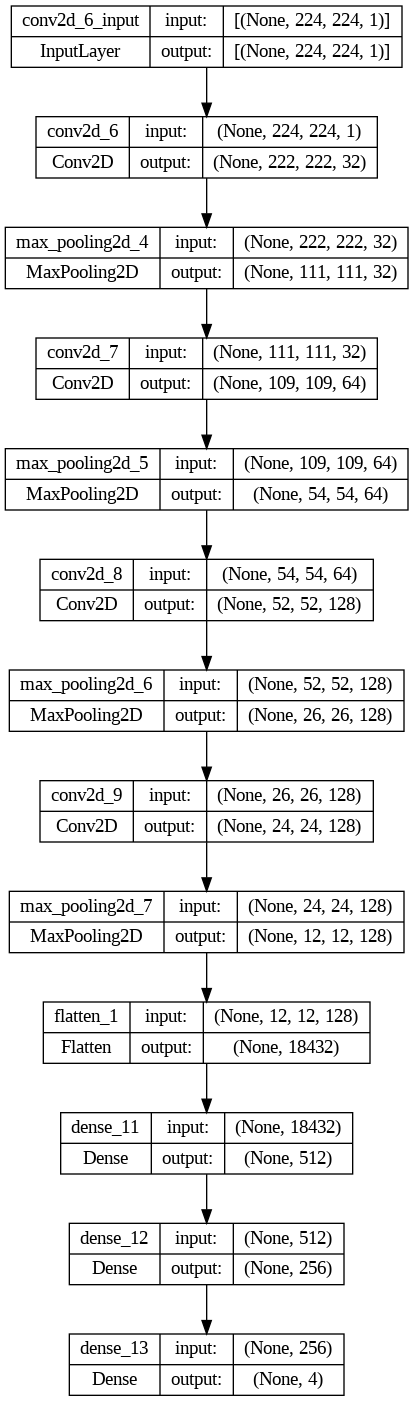

In [49]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [50]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [51]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
93/93 [==============================] - 6s 44ms/step - loss: 4.1380 - accuracy: 0.5233 - val_loss: 0.8721 - val_accuracy: 0.6104 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 3s 35ms/step - loss: 0.7212 - accuracy: 0.6775 - val_loss: 0.7183 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 3s 35ms/step - loss: 0.6403 - accuracy: 0.7166 - val_loss: 0.6529 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 3s 35ms/step - loss: 0.5987 - accuracy: 0.7314 - val_loss: 0.6541 - val_accuracy: 0.6956 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 3s 35ms/step - loss: 0.5791 - accuracy: 0.7335 - val_loss: 0.6771 - val_accuracy: 0.7098 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 3s 35ms/step - loss: 0.6059 - accuracy: 0.7257 - val_loss: 0.6772 - val_accuracy: 0.6956 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 3s 35ms/step - loss: 0.5

CNN Evaluation

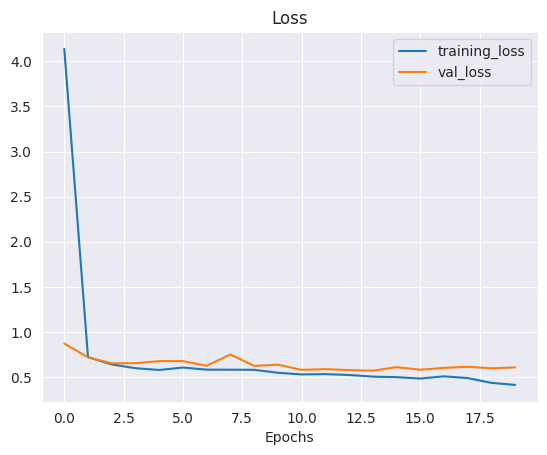

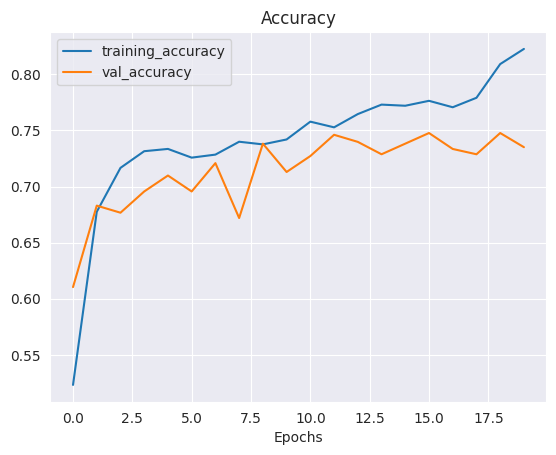

In [52]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 0s 12ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.52      0.54       158
           1       0.99      1.00      0.99       166
           2       0.61      0.50      0.55       154
           3       0.70      0.87      0.78       162

    accuracy                           0.73       640
   macro avg       0.72      0.72      0.72       640
weighted avg       0.72      0.73      0.72       640

Specificity: [0.14695340501792115, 0.350210970464135, 0.13676731793960922, 0.28256513026052105]
Mean Squared Error: : 0.13518506288528442
The average AUC-ROC is 0.9017529657496085


[0.8464646464646465,
 0.6652542372881356,
 0.77431906614786,
 0.7175398633257403,
 0.6646464646464646,
 1.0,
 0.6770428015564203,
 0.621867881548975,
 0.7898989898989899,
 0.6758474576271186,
 0.8501945525291829,
 0.7084282460136674,
 0.6989898989898989,
 0.6588983050847458,
 0.6984435797665369,
 0.9521640091116174]

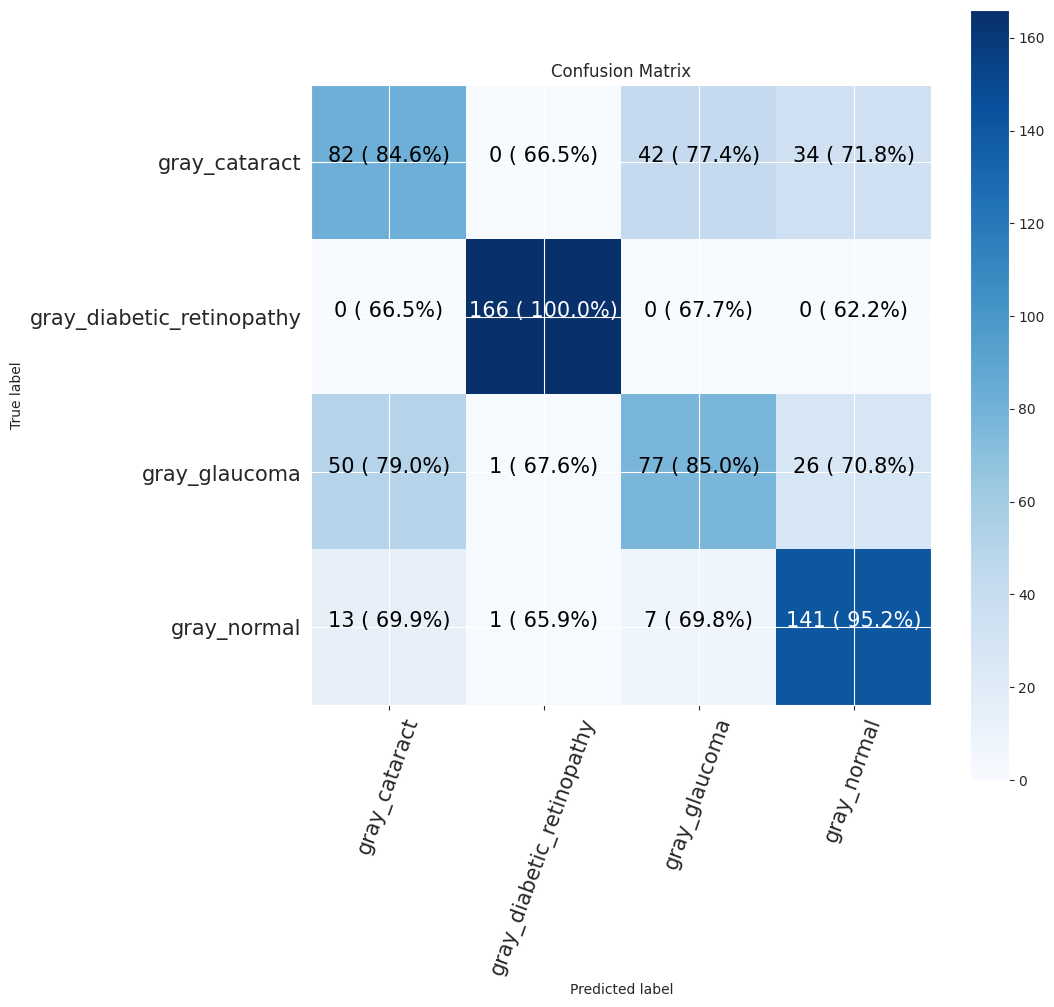

In [53]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


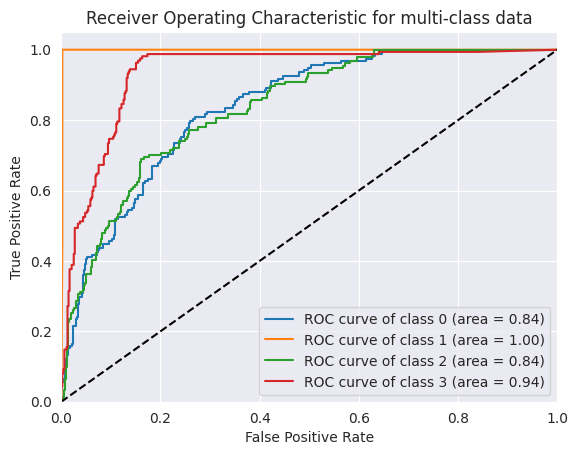

In [54]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [55]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_15 (Dense)            (None, 4)                 4100      
                                                           

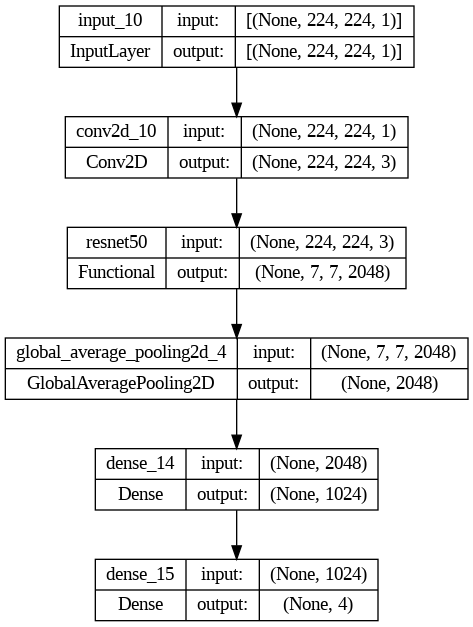

In [56]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [57]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [58]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
93/93 [==============================] - 33s 301ms/step - loss: 0.7427 - accuracy: 0.7402 - val_loss: 0.4694 - val_accuracy: 0.8218 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 25s 267ms/step - loss: 0.3622 - accuracy: 0.8596 - val_loss: 0.3353 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 25s 264ms/step - loss: 0.3221 - accuracy: 0.8752 - val_loss: 0.5677 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 25s 264ms/step - loss: 0.2688 - accuracy: 0.8981 - val_loss: 0.3709 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 25s 265ms/step - loss: 0.2547 - accuracy: 0.9042 - val_loss: 0.2990 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 25s 265ms/step - loss: 0.2039 - accuracy: 0.9221 - val_loss: 0.3367 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 25s 265ms/st

ResNet50 Evaluation

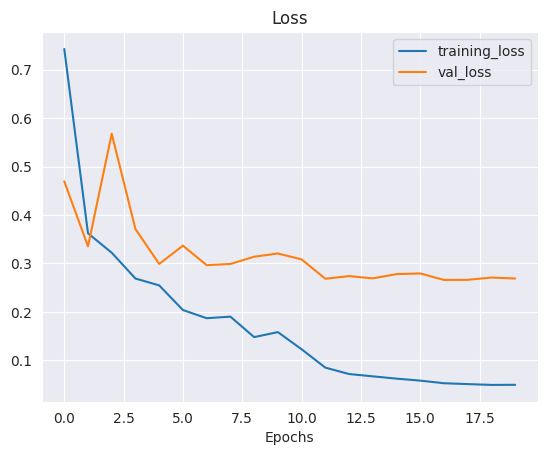

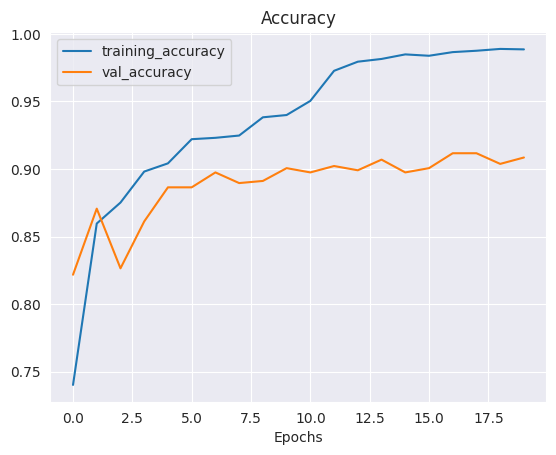

In [59]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2s 90ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       158
           1       0.98      0.99      0.98       166
           2       0.81      0.88      0.85       154
           3       0.89      0.85      0.87       162

    accuracy                           0.90       640
   macro avg       0.90      0.90      0.90       640
weighted avg       0.90      0.90      0.90       640

Specificity: [0.27236580516898606, 0.3445378151260504, 0.2698412698412698, 0.27236580516898606]
Mean Squared Error: : 0.1091051772236824
The average AUC-ROC is 0.9832120848282578


[0.9569672131147541,
 0.6659619450317125,
 0.6976744186046512,
 0.6872427983539094,
 0.6618852459016393,
 0.9957716701902748,
 0.6490486257928119,
 0.6604938271604939,
 0.6987704918032787,
 0.6765327695560254,
 0.9619450317124736,
 0.7037037037037037,
 0.6823770491803278,
 0.6617336152219874,
 0.6913319238900634,
 0.948559670781893]

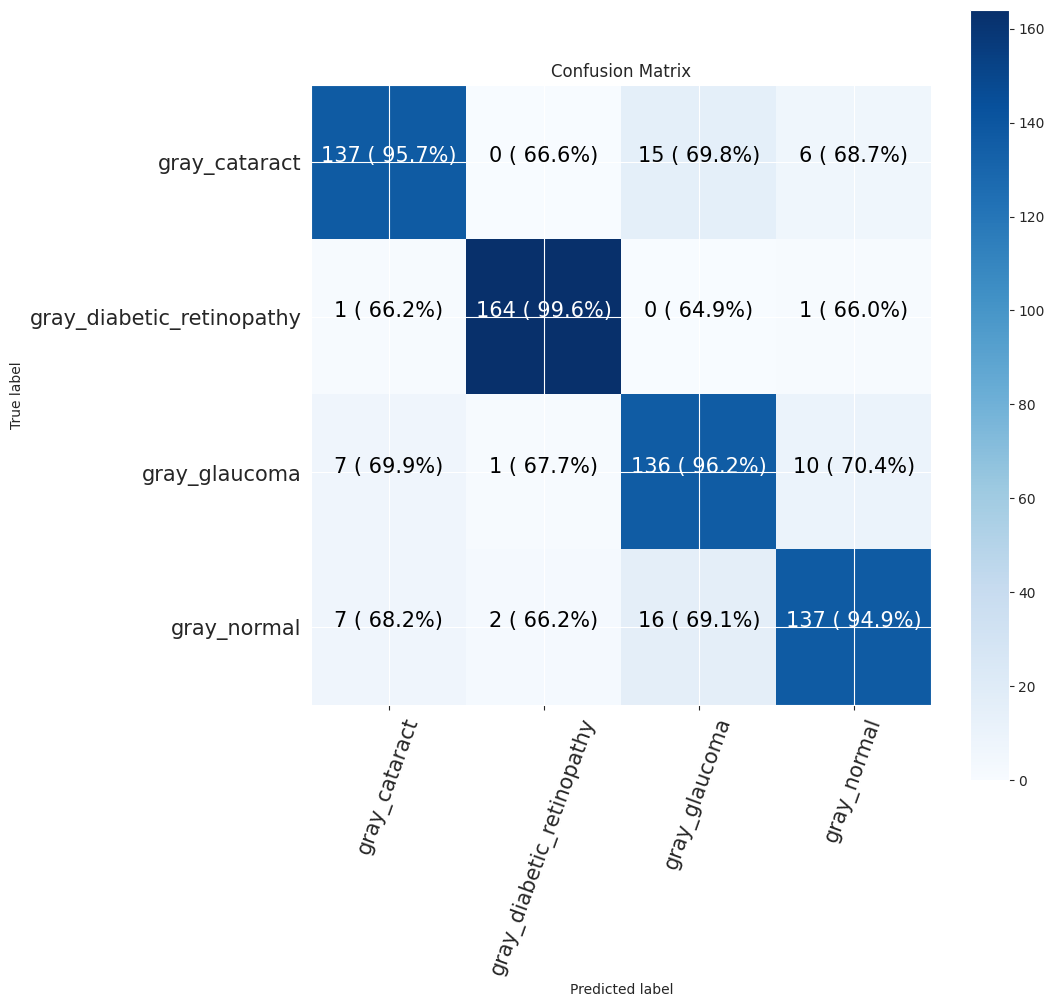

In [60]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


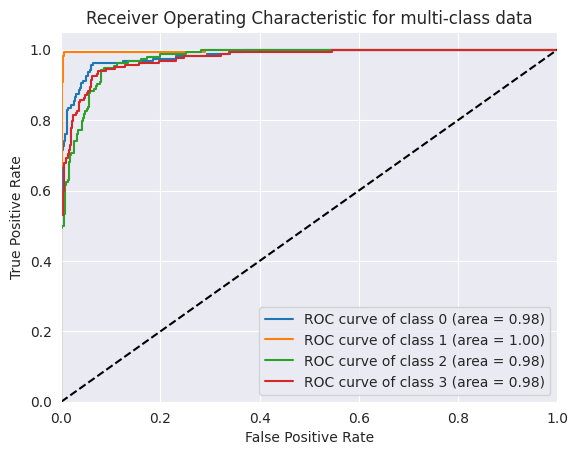

In [61]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [62]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_17 (Dense)            (None, 4)                 4100      
                                                           

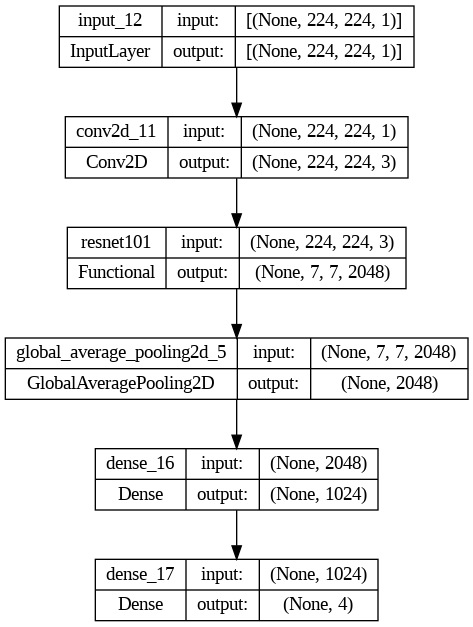

In [63]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [64]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [65]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
93/93 [==============================] - 49s 459ms/step - loss: 0.7114 - accuracy: 0.7814 - val_loss: 0.3691 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 40s 435ms/step - loss: 0.3842 - accuracy: 0.8623 - val_loss: 0.4654 - val_accuracy: 0.8218 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 41s 437ms/step - loss: 0.3475 - accuracy: 0.8593 - val_loss: 0.3126 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 41s 437ms/step - loss: 0.2761 - accuracy: 0.8927 - val_loss: 0.3290 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 41s 436ms/step - loss: 0.2588 - accuracy: 0.9032 - val_loss: 0.4024 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 41s 437ms/step - loss: 0.2703 - accuracy: 0.8947 - val_loss: 0.3176 - val_accuracy: 0.8880 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 41s 437ms/st

ResNet101 Evaluation

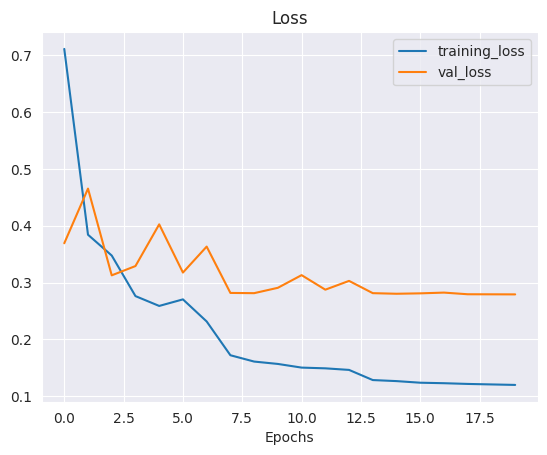

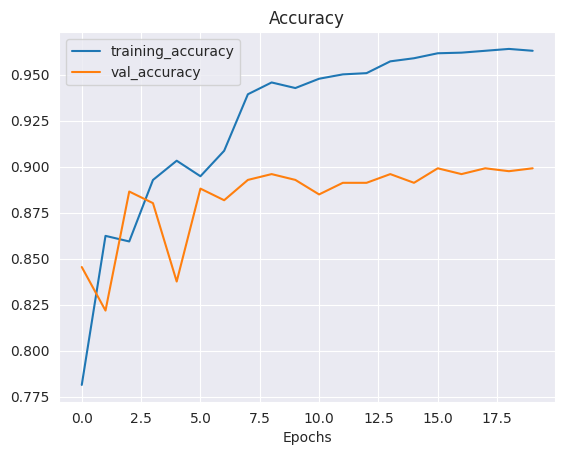

In [66]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 3s 155ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       158
           1       0.99      0.97      0.98       166
           2       0.79      0.76      0.77       154
           3       0.84      0.84      0.84       162

    accuracy                           0.87       640
   macro avg       0.87      0.87      0.87       640
weighted avg       0.87      0.87      0.87       640

Specificity: [0.28256513026052105, 0.33611691022964507, 0.2237093690248566, 0.2698412698412698]
Mean Squared Error: : 0.11342133581638336
The average AUC-ROC is 0.9782579441208294


[0.9640591966173362,
 0.6687631027253669,
 0.7006109979633401,
 0.6826722338204593,
 0.6490486257928119,
 0.989517819706499,
 0.6639511201629328,
 0.6617954070981211,
 0.7209302325581395,
 0.6771488469601677,
 0.924643584521385,
 0.7098121085594989,
 0.6659619450317125,
 0.6645702306079665,
 0.7107942973523421,
 0.9457202505219207]

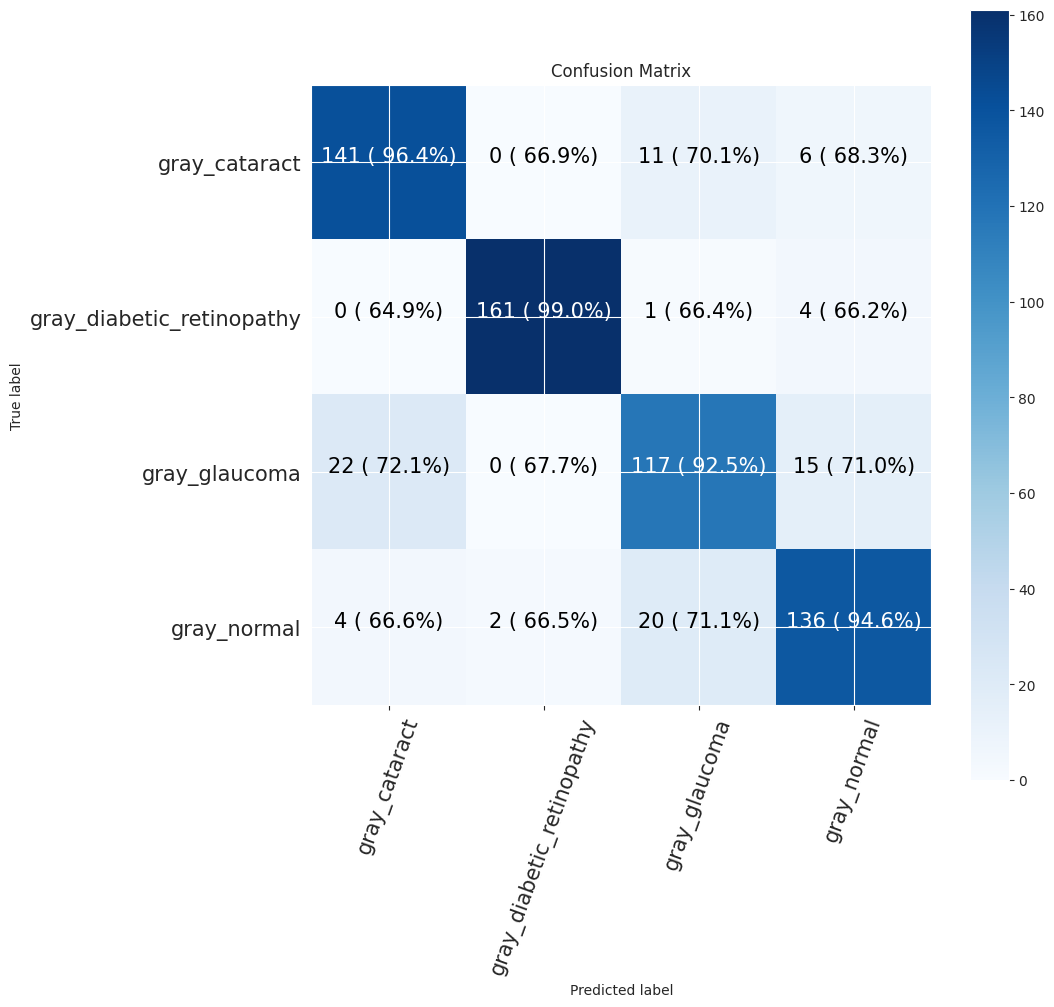

In [67]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


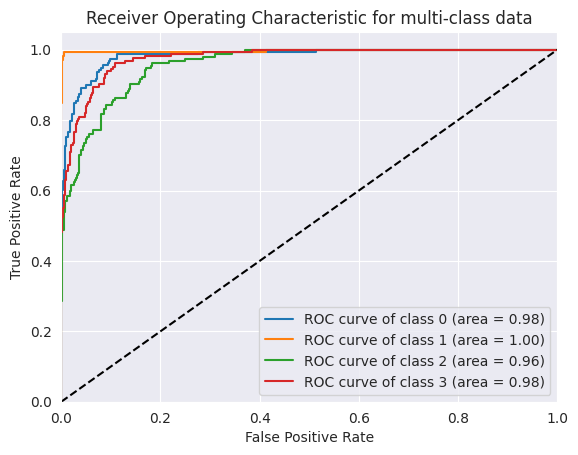

In [68]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [69]:
epoch = 20
batchsize = 64

In [70]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 2964 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 634 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [71]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [72]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_6  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 32)                49184     
                                                                 
 dense_19 (Dense)            (None, 4)                 132       
                                                                 
 activation_2 (Activation)   (None, 4)                 0   

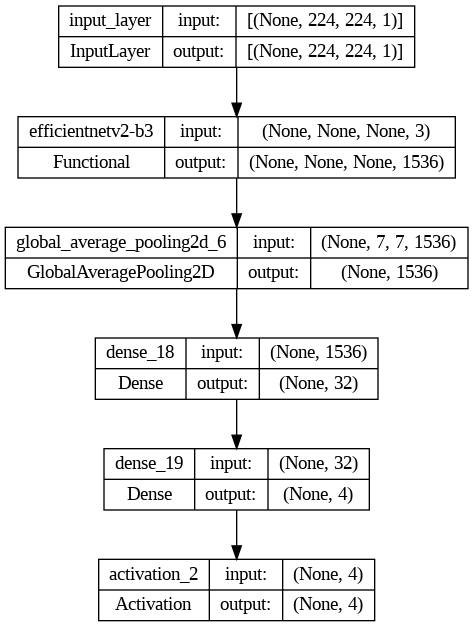

In [73]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [74]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [75]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
47/47 [==============================] - 25s 284ms/step - loss: 0.7607 - accuracy: 0.6869 - val_loss: 0.5568 - val_accuracy: 0.7713 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 9s 196ms/step - loss: 0.5235 - accuracy: 0.7982 - val_loss: 0.4717 - val_accuracy: 0.8139 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 9s 198ms/step - loss: 0.4578 - accuracy: 0.8306 - val_loss: 0.4064 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 9s 197ms/step - loss: 0.4180 - accuracy: 0.8391 - val_loss: 0.4192 - val_accuracy: 0.8391 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 9s 194ms/step - loss: 0.3998 - accuracy: 0.8532 - val_loss: 0.3781 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 9s 193ms/step - loss: 0.3845 - accuracy: 0.8553 - val_loss: 0.3462 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 9s 192ms/step - l

EfficientNetV2B3 Evaluation

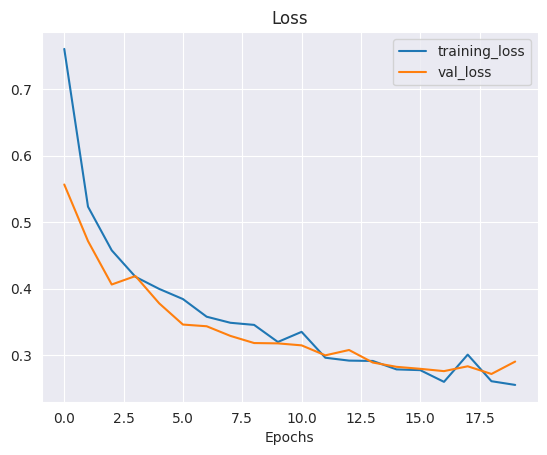

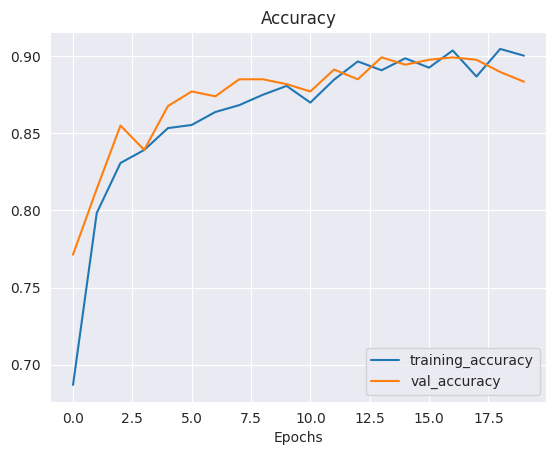

In [76]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 147ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       158
           1       0.98      0.95      0.96       166
           2       0.78      0.84      0.81       154
           3       0.91      0.79      0.84       162

    accuracy                           0.88       640
   macro avg       0.88      0.88      0.88       640
weighted avg       0.88      0.88      0.88       640

Specificity: [0.3008130081300813, 0.3278008298755187, 0.25244618395303325, 0.25]
Mean Squared Error: : 0.11501647531986237
The average AUC-ROC is 0.9787349861676563


[0.9786324786324786,
 0.6694560669456067,
 0.6821052631578948,
 0.6893787575150301,
 0.6495726495726496,
 0.9832635983263598,
 0.6589473684210526,
 0.6713426853707415,
 0.7051282051282052,
 0.6799163179916318,
 0.9473684210526315,
 0.7074148296593187,
 0.6666666666666666,
 0.6673640167364017,
 0.7115789473684211,
 0.9318637274549099]

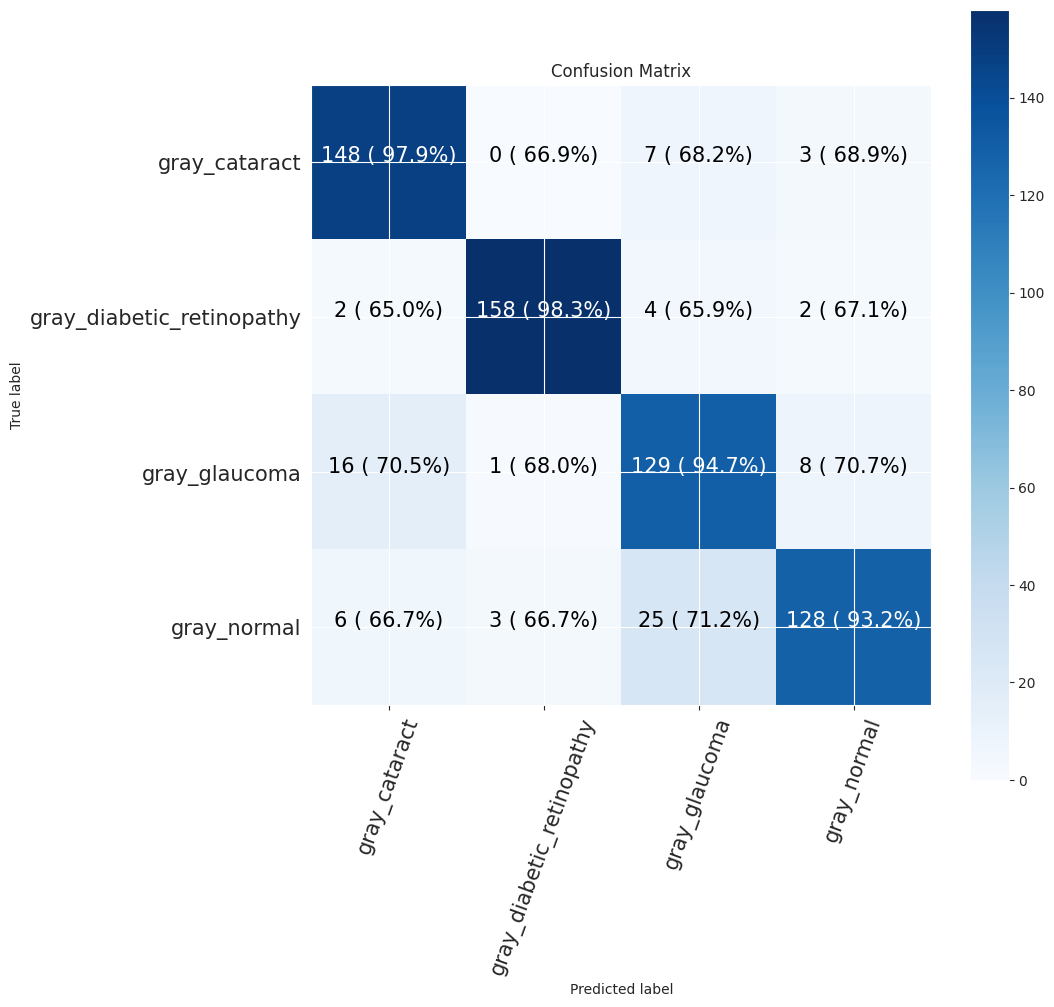

In [77]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


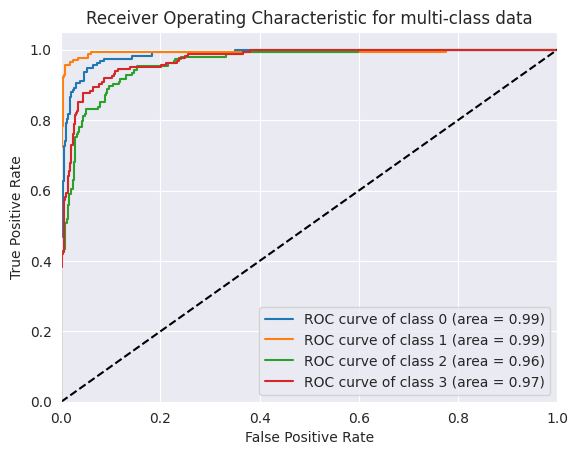

In [78]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [79]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 128)      

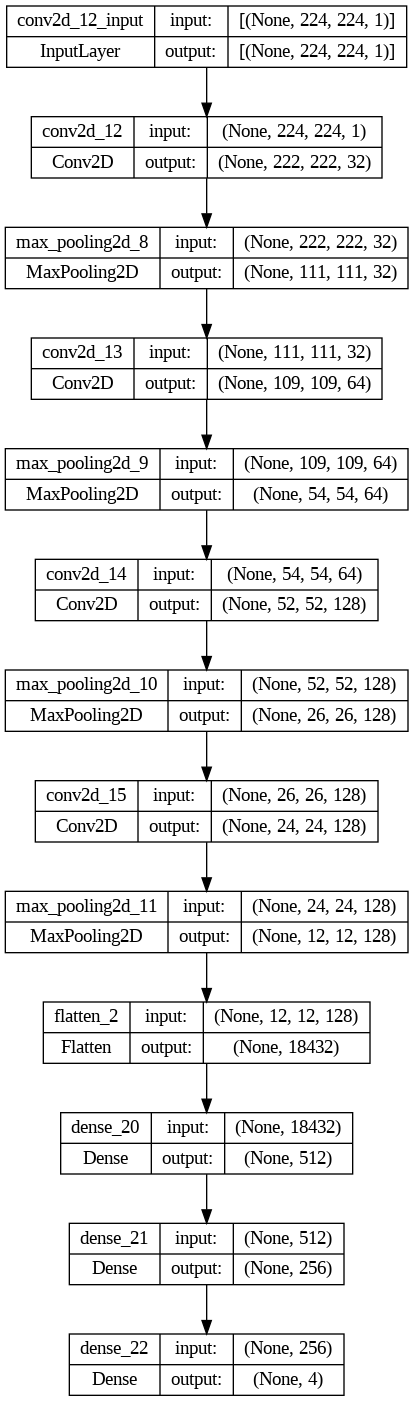

In [80]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [81]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [82]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
47/47 [==============================] - 7s 80ms/step - loss: 6.5132 - accuracy: 0.4973 - val_loss: 0.6637 - val_accuracy: 0.7539 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 3s 66ms/step - loss: 0.7840 - accuracy: 0.6660 - val_loss: 0.8243 - val_accuracy: 0.6388 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 3s 66ms/step - loss: 0.6440 - accuracy: 0.7274 - val_loss: 0.5661 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 3s 67ms/step - loss: 0.5520 - accuracy: 0.7628 - val_loss: 0.5216 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 3s 67ms/step - loss: 0.4910 - accuracy: 0.7925 - val_loss: 0.5284 - val_accuracy: 0.7855 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 3s 66ms/step - loss: 0.4532 - accuracy: 0.8043 - val_loss: 0.4903 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 3s 66ms/step - loss: 0.4

CNN Evaluation

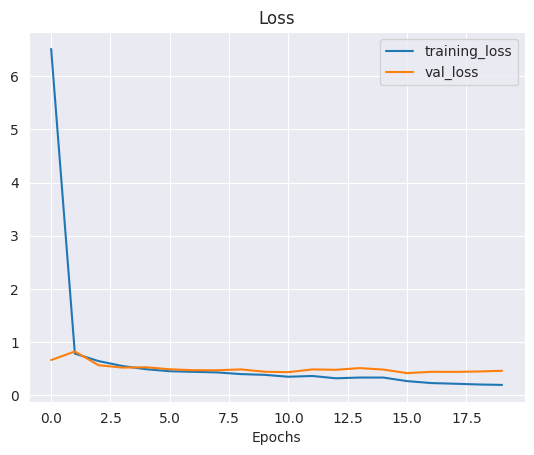

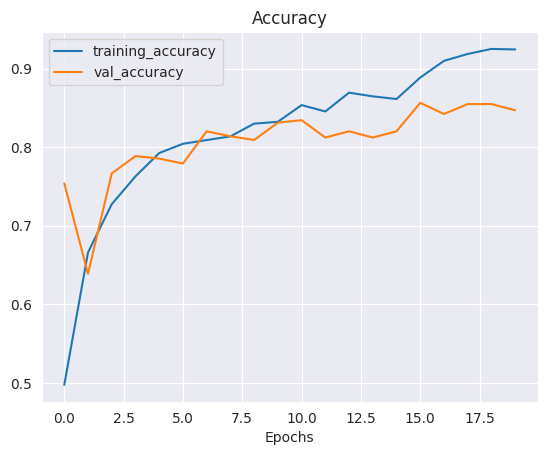

In [83]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       158
           1       0.98      1.00      0.99       166
           2       0.75      0.73      0.74       154
           3       0.76      0.84      0.80       162

    accuracy                           0.84       640
   macro avg       0.83      0.83      0.83       640
weighted avg       0.84      0.84      0.84       640

Specificity: [0.23076923076923078, 0.350210970464135, 0.2144212523719165, 0.2698412698412698]
Mean Squared Error: : 0.11919035017490387
The average AUC-ROC is 0.9525746691893843


[0.9235412474849095,
 0.6645435244161358,
 0.7204081632653061,
 0.6948051948051948,
 0.6659959758551308,
 1.0,
 0.6612244897959184,
 0.6406926406926406,
 0.7203219315895373,
 0.6751592356687898,
 0.9163265306122449,
 0.7207792207792207,
 0.6901408450704225,
 0.6602972399150743,
 0.7020408163265306,
 0.9437229437229437]

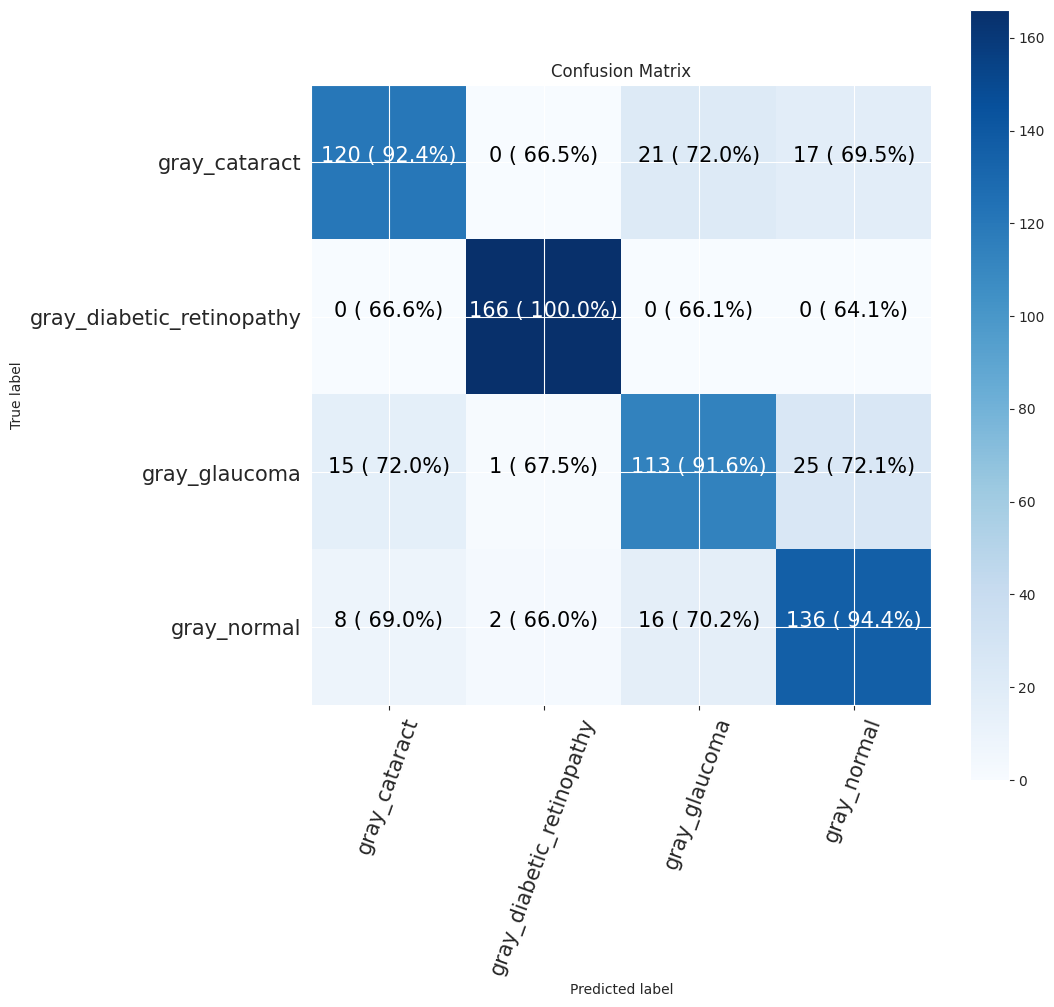

In [84]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


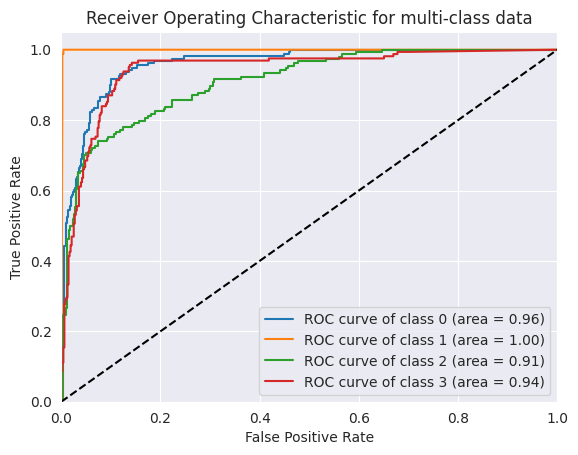

In [85]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [86]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_23 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_24 (Dense)            (None, 4)                 4100      
                                                           

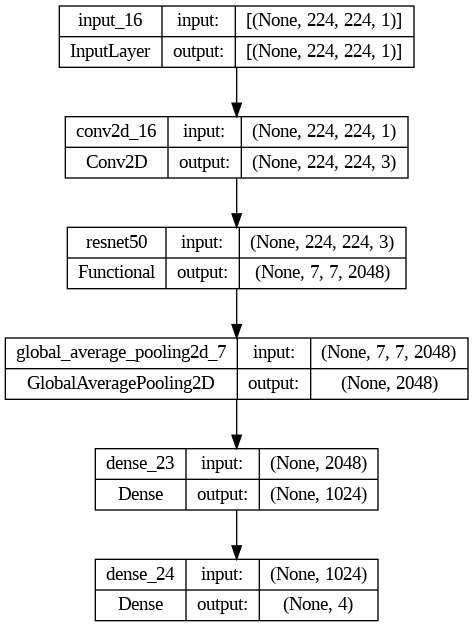

In [87]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [88]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [89]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
47/47 [==============================] - 34s 563ms/step - loss: 0.8984 - accuracy: 0.7186 - val_loss: 0.5360 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 24s 510ms/step - loss: 0.3979 - accuracy: 0.8495 - val_loss: 0.3912 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 24s 505ms/step - loss: 0.3642 - accuracy: 0.8674 - val_loss: 0.4538 - val_accuracy: 0.8391 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 24s 505ms/step - loss: 0.3028 - accuracy: 0.8910 - val_loss: 0.2956 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 24s 507ms/step - loss: 0.2552 - accuracy: 0.9028 - val_loss: 0.3051 - val_accuracy: 0.8880 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 24s 507ms/step - loss: 0.2464 - accuracy: 0.9096 - val_loss: 0.3460 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 24s 506ms/st

ResNet50 Evaluation

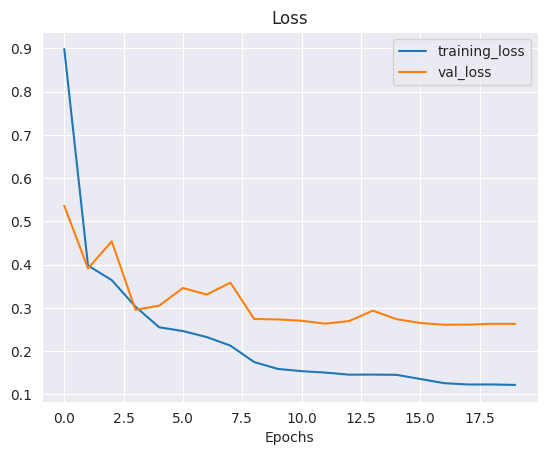

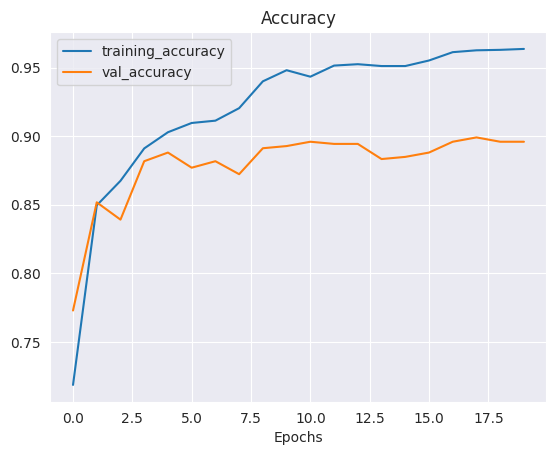

In [90]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 176ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       158
           1       0.98      0.99      0.99       166
           2       0.84      0.77      0.80       154
           3       0.84      0.90      0.87       162

    accuracy                           0.89       640
   macro avg       0.89      0.89      0.89       640
weighted avg       0.89      0.89      0.89       640

Specificity: [0.28, 0.3473684210526316, 0.22840690978886757, 0.29554655870445345]
Mean Squared Error: : 0.11238214373588562
The average AUC-ROC is 0.9786822625308444


[0.9628099173553719,
 0.6652542372881356,
 0.7048192771084337,
 0.6759656652360515,
 0.6590909090909091,
 0.9978813559322034,
 0.6666666666666666,
 0.6437768240343348,
 0.7066115702479339,
 0.6779661016949152,
 0.929718875502008,
 0.7145922746781116,
 0.6714876033057852,
 0.6588983050847458,
 0.6987951807228916,
 0.9656652360515021]

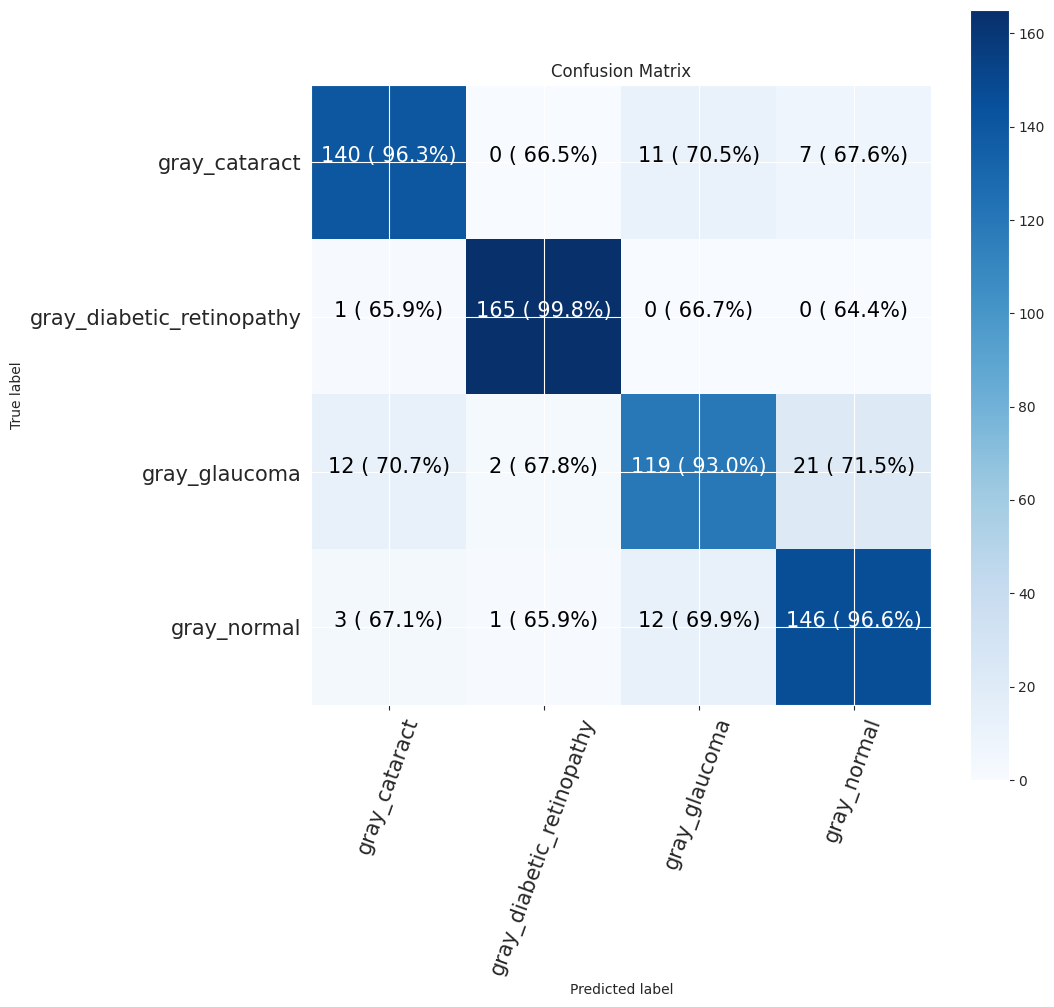

In [91]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


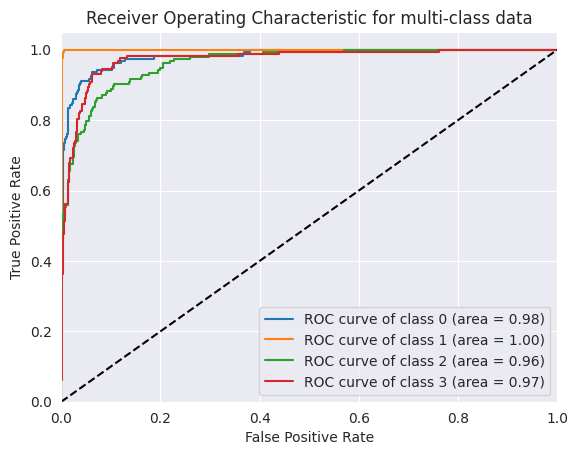

In [92]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [93]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_26 (Dense)            (None, 4)                 4100      
                                                           

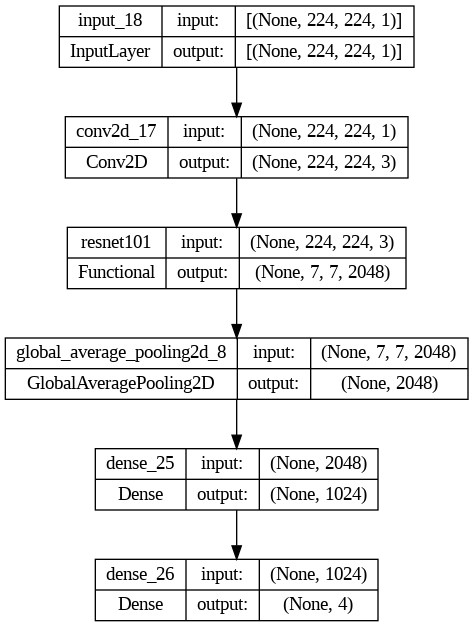

In [94]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [95]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [96]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
47/47 [==============================] - 48s 870ms/step - loss: 0.8424 - accuracy: 0.7146 - val_loss: 0.4249 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 39s 819ms/step - loss: 0.3958 - accuracy: 0.8472 - val_loss: 0.3808 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 39s 821ms/step - loss: 0.3229 - accuracy: 0.8772 - val_loss: 0.4076 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 39s 824ms/step - loss: 0.3243 - accuracy: 0.8758 - val_loss: 0.3647 - val_accuracy: 0.8407 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 39s 821ms/step - loss: 0.2601 - accuracy: 0.9025 - val_loss: 0.3544 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 39s 821ms/step - loss: 0.2643 - accuracy: 0.8995 - val_loss: 0.3562 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 39s 822ms/st

ResNet101 Evaluation

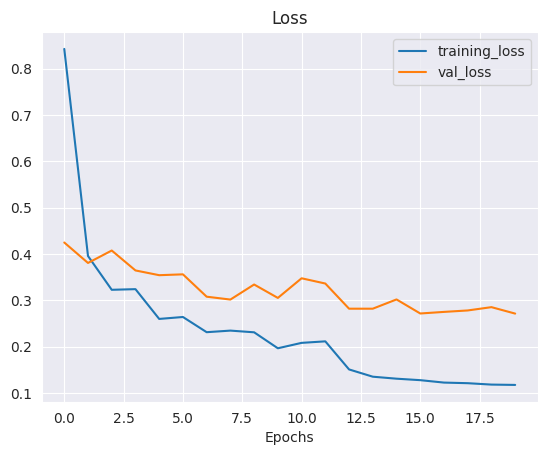

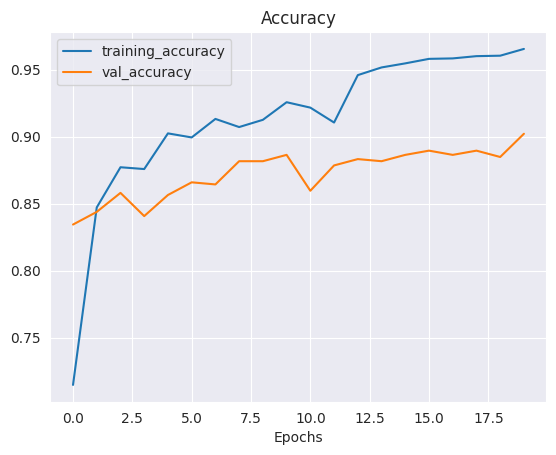

In [97]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 3s 292ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       158
           1       0.98      0.99      0.98       166
           2       0.87      0.71      0.78       154
           3       0.84      0.90      0.87       162

    accuracy                           0.88       640
   macro avg       0.88      0.88      0.88       640
weighted avg       0.88      0.88      0.88       640

Specificity: [0.2903225806451613, 0.3445378151260504, 0.20754716981132076, 0.29292929292929293]
Mean Squared Error: : 0.11200874298810959
The average AUC-ROC is 0.9796139851558511


[0.9700854700854701,
 0.6652542372881356,
 0.7076023391812866,
 0.6745182012847966,
 0.6452991452991453,
 0.9957627118644068,
 0.6783625730994152,
 0.6466809421841542,
 0.717948717948718,
 0.6758474576271186,
 0.9142300194931774,
 0.715203426124197,
 0.6666666666666666,
 0.663135593220339,
 0.6998050682261209,
 0.9635974304068522]

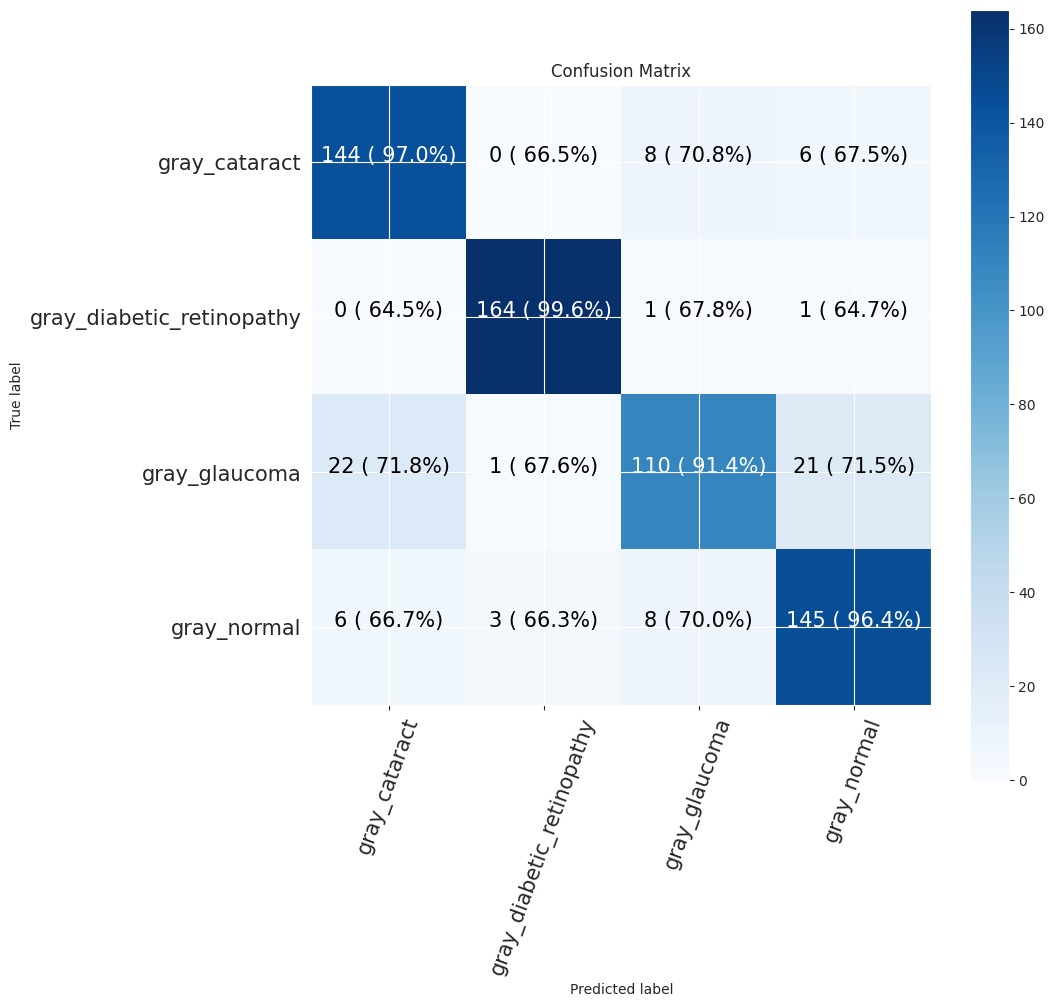

In [98]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


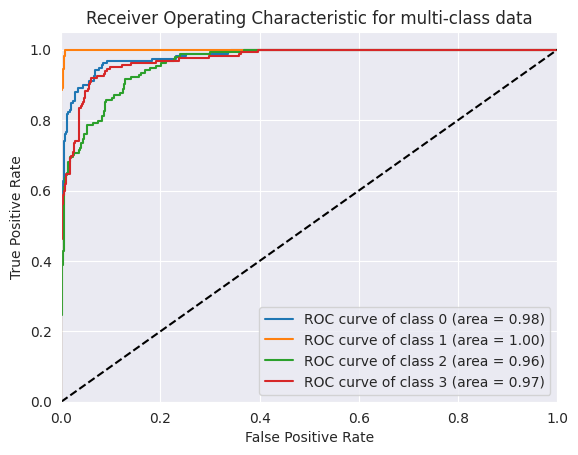

In [99]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()